In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as lines
from cycler import cycler

from scipy import signal
from scipy import fft
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lowrankappr as lra
from lowrankappr import DynPCA
import utils

from ipywidgets import interact, fixed

%load_ext autoreload
%autoreload 2

# Energy Stock prices

In [2]:
ener_data = pd.read_excel("energy_companies/Energy_Stock_prices.xlsx", header=0, sheet_name=2)

In [3]:
ener_data.head()

,Date,NEXTERA ENERGY,DUKE ENERGY,DOMINION ENERGY,VALERO ENERGY,EVERSOURCE ENERGY,WEC ENERGY GROUP,DTE ENERGY,CMS ENERGY,ATMOS ENERGY,NOBLE ENERGY,OGE ENERGY,SOUTHWESTERN ENERGY,EARTHSTONE ENERGY 'A',SEMPRA EN.,CENTERPOINT EN.
0,2009-09-21,-0.001091,-0.013245,-0.004086,-0.003966,-0.007383,-0.004873,-0.002272,0.000744,-0.002810,-0.012858,-0.003332,-0.015795,0.051293,-0.000196,0.000800
1,2009-09-22,-0.012263,-0.002543,-0.003223,0.010371,-0.014932,-0.005120,-0.013454,-0.004474,-0.008478,0.011551,0.001213,0.023938,0.000000,-0.012452,-0.001601
2,2009-09-23,-0.007950,0.000636,-0.000881,-0.026387,-0.006288,0.000223,0.008037,0.000000,0.001772,-0.023236,-0.005774,-0.036242,0.018576,-0.003986,-0.008045
3,2009-09-24,0.001299,0.005709,0.005857,-0.045944,0.000420,-0.000446,0.003994,-0.002245,-0.001772,-0.019532,0.002739,-0.021247,0.000000,-0.003601,-0.009740
4,2009-09-25,0.008308,0.001264,-0.001753,0.027617,0.001680,-0.006944,-0.002566,0.000000,-0.003198,-0.001822,-0.002130,-0.021952,0.000000,-0.006232,-0.000816


In [11]:
n_dim= ener_data.shape[1]-1
ener_data = ener_data.set_index("Date")

In [12]:
ener_data.head()

,NEXTERA ENERGY,DUKE ENERGY,DOMINION ENERGY,VALERO ENERGY,EVERSOURCE ENERGY,WEC ENERGY GROUP,DTE ENERGY,CMS ENERGY,ATMOS ENERGY,NOBLE ENERGY,OGE ENERGY,SOUTHWESTERN ENERGY,EARTHSTONE ENERGY 'A',SEMPRA EN.,CENTERPOINT EN.
Date,,,,,,,,,,,,,,,
2009-09-21,-0.001091,-0.013245,-0.004086,-0.003966,-0.007383,-0.004873,-0.002272,0.000744,-0.002810,-0.012858,-0.003332,-0.015795,0.051293,-0.000196,0.000800
2009-09-22,-0.012263,-0.002543,-0.003223,0.010371,-0.014932,-0.005120,-0.013454,-0.004474,-0.008478,0.011551,0.001213,0.023938,0.000000,-0.012452,-0.001601
2009-09-23,-0.007950,0.000636,-0.000881,-0.026387,-0.006288,0.000223,0.008037,0.000000,0.001772,-0.023236,-0.005774,-0.036242,0.018576,-0.003986,-0.008045
2009-09-24,0.001299,0.005709,0.005857,-0.045944,0.000420,-0.000446,0.003994,-0.002245,-0.001772,-0.019532,0.002739,-0.021247,0.000000,-0.003601,-0.009740
2009-09-25,0.008308,0.001264,-0.001753,0.027617,0.001680,-0.006944,-0.002566,0.000000,-0.003198,-0.001822,-0.002130,-0.021952,0.000000,-0.006232,-0.000816


## simple TS plot

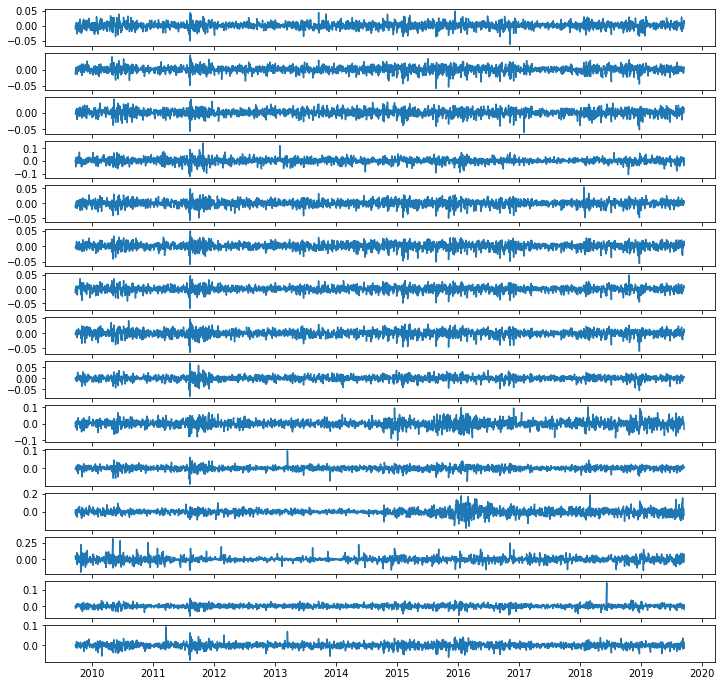

In [13]:
f, ax = plt.subplots(n_dim,1, figsize=(12,12))
for i, c in enumerate(ener_data.columns):
    ax[i].plot(ener_data[c])
plt.show()

### 1-lag diff.
(It will not be used.)

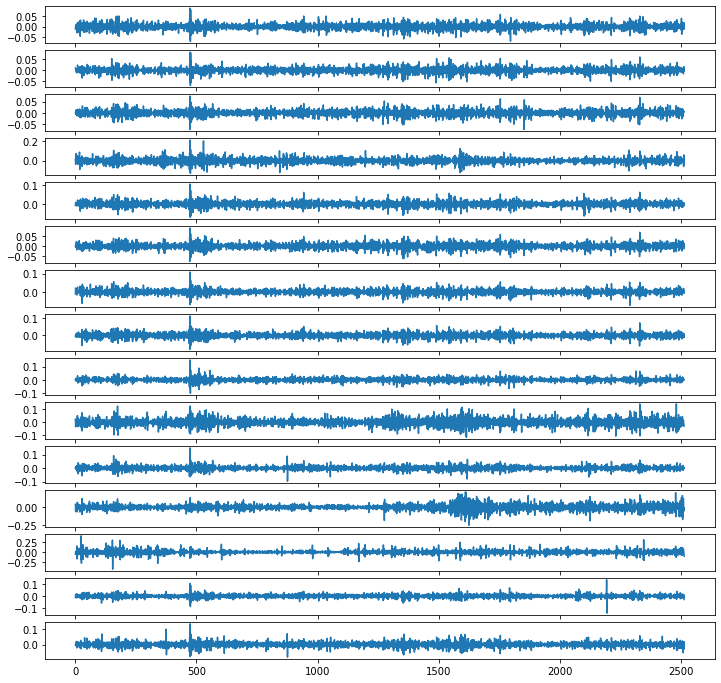

In [22]:
# ener_data = ener_data.astype(np.float)

ener_data_firstrow = ener_data.iloc[0,:].to_frame().transpose()

f, ax = plt.subplots(n_dim,1, figsize=(12,12))
for i, c in enumerate(ener_data.columns):
    ax[i].plot(ener_data[c].iloc[1:].values-ener_data[c].iloc[:-1].values)
plt.show()

# dynPCA
 * 3 components
 * $\sqrt{n}$ Fourier frequencies

(2515, 14)
number of estimated frequencies: 50
dim 0 done
dim 1 done
dim 2 done
dim 3 done
dim 4 done
dim 5 done
dim 6 done
dim 7 done
dim 8 done
dim 9 done
dim 10 done
dim 11 done
dim 12 done
dim 13 done
length: 50
[[[ 4.31454552e-08+0.j -1.55938631e-06+0.j -7.30016836e-06+0.j ...
   -1.15481207e-05+0.j -1.02371530e-06+0.j -1.03407945e-06+0.j]
  [-1.10525207e-06+0.j -2.95257064e-06+0.j -5.17711169e-06+0.j ...
    3.76957729e-07+0.j -2.40807185e-06+0.j -1.28987222e-06+0.j]
  [ 4.29832880e-06+0.j  3.71843885e-06+0.j  2.41631227e-07+0.j ...
    1.42985327e-05+0.j  1.58570924e-06+0.j  6.16338502e-06+0.j]
  ...
  [ 9.95191385e-06+0.j -7.24386496e-07+0.j  3.35187906e-05+0.j ...
   -3.43515821e-05+0.j  3.58630450e-06+0.j  1.82131607e-05+0.j]
  [ 2.26379984e-06+0.j  3.84593761e-07+0.j -2.48834112e-06+0.j ...
   -1.46601169e-05+0.j  1.07529479e-06+0.j  3.03942988e-06+0.j]
  [-5.86139095e-07+0.j -7.47342199e-07+0.j  1.35627977e-06+0.j ...
   -6.50440370e-06+0.j  1.07654216e-06+0.j -2.02690771e-

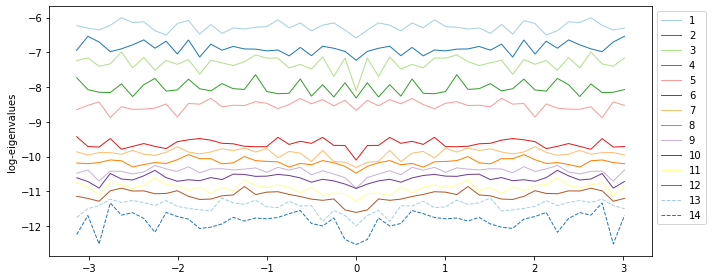

data:  (2515, 14, 1)
PC_dim:  (2515, 3, 1)
sp_array:  (50, 14, 14)
reduced_dim:  (2515, 3, 1)
restored_dim:  (2515, 14, 1)

 Explained variance per dim:
DUKE ENERGY              0.695620
DOMINION ENERGY          0.672706
VALERO ENERGY            0.422007
EVERSOURCE ENERGY        0.763626
WEC ENERGY GROUP         0.772301
DTE ENERGY               0.785569
CMS ENERGY               0.785978
ATMOS ENERGY             0.693267
NOBLE ENERGY             0.604185
OGE ENERGY               0.719859
SOUTHWESTERN ENERGY      0.936691
EARTHSTONE ENERGY 'A'    0.984145
SEMPRA EN.               0.636056
CENTERPOINT EN.          0.675394
dtype: float64

 Error scores after restoration:
MSE: 5.8392708300208307e-05
MAE: 0.005158916522529799
R2: 0.7285155341612677
Comp. ratio: 0.3335700085203067
CPU times: user 1.28 s, sys: 837 ms, total: 2.12 s
Wall time: 1.12 s


In [16]:
%%time

# data_subset = pd.DataFrame(np.log(ener_data.iloc[1:,2:].values/ener_data.iloc[:-1,2:].values))
# data_subset = pd.DataFrame(ener_data.iloc[2:,2:].values-ener_data.iloc[1:-1,2:].values)
data_subset = ener_data.iloc[1:,1:]
print(data_subset.shape)
# skaler = StandardScaler()
# data_subset = pd.DataFrame(skaler.fit_transform(data_subset.values),
#                         index=data_subset.index, columns=data_subset.columns)


npers = int(np.sqrt(data_subset.shape[0]))
print("number of estimated frequencies: {}".format(npers))

dyn_pca_obj = DynPCA(n_components=3, densif_method="linear", n_perseg=npers)
dyn_pca_obj.fit(data_subset, use_M_matrices=True)

# dyn_pca_obj.plot_eig_vals(log_scale=False, figsize=(15,6))
# plt.show()

dyn_pca_obj.plot_eig_vals(log_scale=True, figsize=(10,4))
plt.show()

PCs = dyn_pca_obj.transform(data_subset)
restore = dyn_pca_obj.inverse_transform(PCs)

print("\n Explained variance per dim:")
print(np.var(restore)/ np.var(data_subset))

print("\n Error scores after restoration:")
print("MSE: {}".format(mean_squared_error(data_subset, restore)))
print("MAE: {}".format(mean_absolute_error(data_subset, restore)))
print("R2: {}".format(r2_score(data_subset, restore)))

print("Comp. ratio: {}".format(dyn_pca_obj.compression_ratio()))


## weights across frequencies


 Weights inside the first PC:


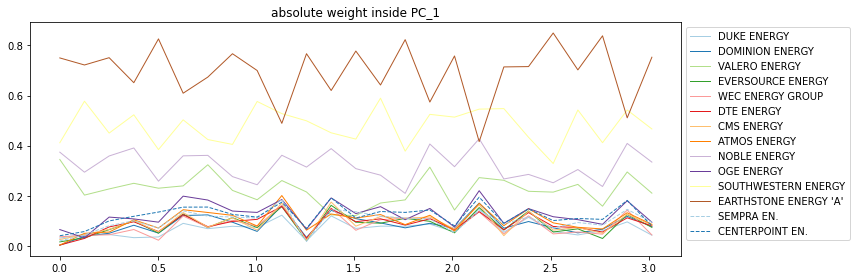


 Weights inside the second PC:


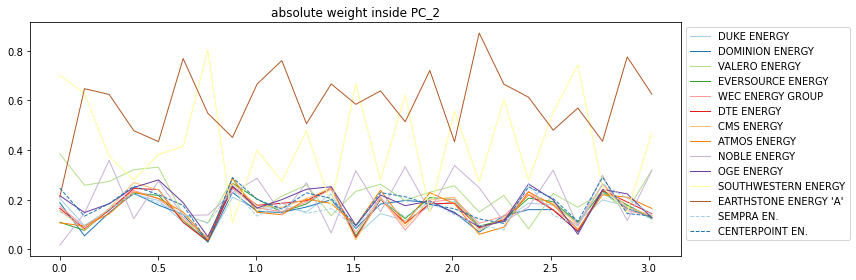

In [17]:
print("\n Weights inside the first PC:")
dyn_pca_obj.plot_pc_weights(1)
# plt.savefig("pc1_weight.png")
plt.show()

print("\n Weights inside the second PC:")
dyn_pca_obj.plot_pc_weights(2)
# plt.savefig("pc2_weight.png")
plt.show()

## Plot of dynPCs

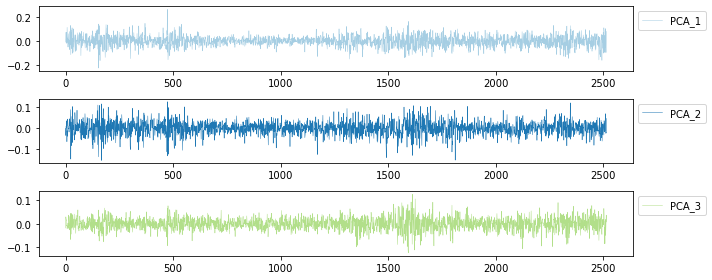

In [18]:
dyn_pca_obj.plot_pcs(PCs, figsize=(10,4))

## The restored time series over the original

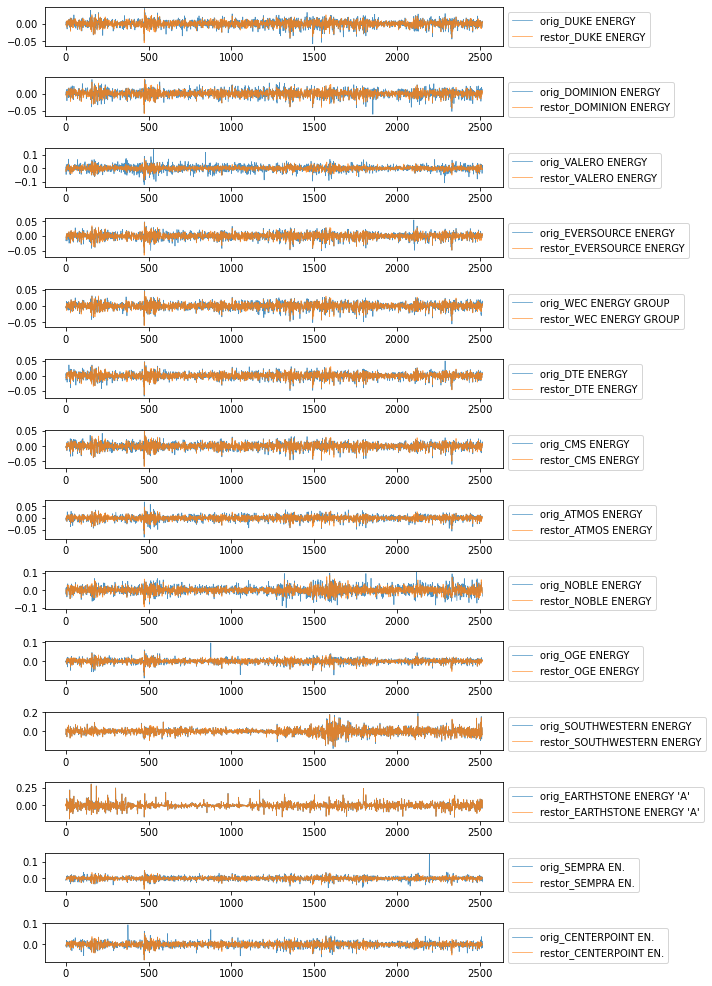

In [19]:
utils.simple_dual_plot(data_subset, restore, 0, data_subset.shape[0], ['orig', 'restor'], figsize = (10,15))

### In the case of standard scaling of the time series
(This does not work if there were no scaling as preprocessing.)

In [ ]:
data_subset_back = data_subset
data_subset_back = pd.DataFrame(skaler.inverse_transform(data_subset.values),
                        index=data_subset.index, columns=data_subset.columns)

restore_back = restore
restore_back = pd.DataFrame(skaler.inverse_transform(restore_back.values),
                        index=restore_back.index, columns=restore_back.columns)

data_subset_back = pd.concat([ener_data_firstrow, np.exp(data_subset_back)], ignore_index=True)
data_subset_back = data_subset_back.cumprod()

restore_back = pd.concat([ener_data_firstrow, np.exp(restore_back)], ignore_index=True)
restore_back = restore_back.cumprod()

In [ ]:
utils.simple_dual_plot(data_subset_back, restore_back, 0, data_subset.shape[0], ['orig', 'restor'], figsize = (10,5))